**Introduction**

This kernel is an attempt to use every trick in the books to unleash the full power of Linear Regression, including a lot of preprocessing and a look at several Regularization algorithms.

At the time of writing, it achieves a score of about 0.121 on the public LB, just using regression, no RF, no xgboost, no ensembling etc. All comments/corrections are more than welcome.

In [18]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [19]:
# Get data
train = pd.read_csv("house prediction data/train.csv")
test = pd.read_csv("house prediction data/test.csv")
test['SalePrice'] = np.zeros((test.shape[0],), dtype=np.float)
print("train : " + str(train.shape))
print("test: " + str(test.shape))

train : (1460, 81)
test: (1459, 81)


In [20]:
# Check for duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


**Preprocessing**

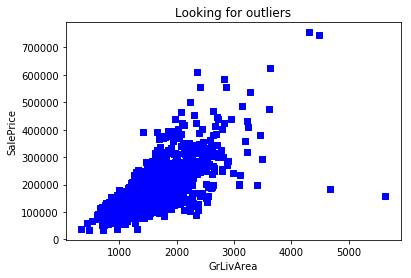

In [21]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.  
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [22]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

In [23]:
all_df = pd.concat([train, test])
print("train : " + str(train.shape))
print("test: " + str(test.shape))
print('concate df: ', all_df.shape)

train : (1456, 80)
test: (1459, 80)
concate df:  (2915, 80)


Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [24]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
all_df.loc[:, "Alley"] = all_df.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
all_df.loc[:, "BedroomAbvGr"] = all_df.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
all_df.loc[:, "BsmtQual"] = all_df.loc[:, "BsmtQual"].fillna("No")
all_df.loc[:, "BsmtCond"] = all_df.loc[:, "BsmtCond"].fillna("No")
all_df.loc[:, "BsmtExposure"] = all_df.loc[:, "BsmtExposure"].fillna("No")
all_df.loc[:, "BsmtFinType1"] = all_df.loc[:, "BsmtFinType1"].fillna("No")
all_df.loc[:, "BsmtFinType2"] = all_df.loc[:, "BsmtFinType2"].fillna("No")
all_df.loc[:, "BsmtFullBath"] = all_df.loc[:, "BsmtFullBath"].fillna(0)
all_df.loc[:, "BsmtHalfBath"] = all_df.loc[:, "BsmtHalfBath"].fillna(0)
all_df.loc[:, "BsmtUnfSF"] = all_df.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
all_df.loc[:, "CentralAir"] = all_df.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
all_df.loc[:, "Condition1"] = all_df.loc[:, "Condition1"].fillna("Norm")
all_df.loc[:, "Condition2"] = all_df.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
all_df.loc[:, "EnclosedPorch"] = all_df.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
all_df.loc[:, "ExterCond"] = all_df.loc[:, "ExterCond"].fillna("TA")
all_df.loc[:, "ExterQual"] = all_df.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
all_df.loc[:, "Fence"] = all_df.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
all_df.loc[:, "FireplaceQu"] = all_df.loc[:, "FireplaceQu"].fillna("No")
all_df.loc[:, "Fireplaces"] = all_df.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
all_df.loc[:, "Functional"] = all_df.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
all_df.loc[:, "GarageType"] = all_df.loc[:, "GarageType"].fillna("No")
all_df.loc[:, "GarageFinish"] = all_df.loc[:, "GarageFinish"].fillna("No")
all_df.loc[:, "GarageQual"] = all_df.loc[:, "GarageQual"].fillna("No")
all_df.loc[:, "GarageCond"] = all_df.loc[:, "GarageCond"].fillna("No")
all_df.loc[:, "GarageArea"] = all_df.loc[:, "GarageArea"].fillna(0)
all_df.loc[:, "GarageCars"] = all_df.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
all_df.loc[:, "HalfBath"] = all_df.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
all_df.loc[:, "HeatingQC"] = all_df.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
all_df.loc[:, "KitchenAbvGr"] = all_df.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
all_df.loc[:, "KitchenQual"] = all_df.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
all_df.loc[:, "LotFrontage"] = all_df.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
all_df.loc[:, "LotShape"] = all_df.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
all_df.loc[:, "MasVnrType"] = all_df.loc[:, "MasVnrType"].fillna("None")
all_df.loc[:, "MasVnrArea"] = all_df.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
all_df.loc[:, "MiscFeature"] = all_df.loc[:, "MiscFeature"].fillna("No")
all_df.loc[:, "MiscVal"] = all_df.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
all_df.loc[:, "OpenPorchSF"] = all_df.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
all_df.loc[:, "PavedDrive"] = all_df.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
all_df.loc[:, "PoolQC"] = all_df.loc[:, "PoolQC"].fillna("No")
all_df.loc[:, "PoolArea"] = all_df.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
all_df.loc[:, "SaleCondition"] = all_df.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
all_df.loc[:, "ScreenPorch"] = all_df.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
all_df.loc[:, "TotRmsAbvGrd"] = all_df.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
all_df.loc[:, "Utilities"] = all_df.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
all_df.loc[:, "WoodDeckSF"] = all_df.loc[:, "WoodDeckSF"].fillna(0)

In [25]:
# Some numerical features are actually really categories
all_df = all_df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [26]:
# Encode some categorical features as ordered numbers when there is information in the order
all_df = all_df.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Then we will create new features, in 3 ways : 

 1. Simplifications of existing features
 2. Combinations of existing features
 3. Polynomials on the top 10 existing features

In [27]:
# Create new features
# 1* Simplifications of existing features
all_df["SimplOverallQual"] = all_df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
all_df["SimplOverallCond"] = all_df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
all_df["SimplPoolQC"] = all_df.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
all_df["SimplGarageCond"] = all_df.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
all_df["SimplGarageQual"] = all_df.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_df["SimplFunctional"] = all_df.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
all_df["SimplKitchenQual"] = all_df.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_df["SimplHeatingQC"] = all_df.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
all_df["SimplBsmtFinType1"] = all_df.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
all_df["SimplBsmtFinType2"] = all_df.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
all_df["SimplBsmtCond"] = all_df.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
all_df["SimplBsmtQual"] = all_df.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
all_df["SimplExterCond"] = all_df.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
all_df["SimplExterQual"] = all_df.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
all_df["OverallGrade"] = all_df["OverallQual"] * all_df["OverallCond"]
# Overall quality of the garage
all_df["GarageGrade"] = all_df["GarageQual"] * all_df["GarageCond"]
# Overall quality of the exterior
all_df["ExterGrade"] = all_df["ExterQual"] * all_df["ExterCond"]
# Overall kitchen score
all_df["KitchenScore"] = all_df["KitchenAbvGr"] * all_df["KitchenQual"]
# Overall fireplace score
all_df["FireplaceScore"] = all_df["Fireplaces"] * all_df["FireplaceQu"]
# Overall garage score
all_df["GarageScore"] = all_df["GarageArea"] * all_df["GarageQual"]
# Overall pool score
all_df["PoolScore"] = all_df["PoolArea"] * all_df["PoolQC"]
# Simplified overall quality of the house
all_df["SimplOverallGrade"] = all_df["SimplOverallQual"] * all_df["SimplOverallCond"]
# Simplified overall quality of the exterior
all_df["SimplExterGrade"] = all_df["SimplExterQual"] * all_df["SimplExterCond"]
# Simplified overall pool score
all_df["SimplPoolScore"] = all_df["PoolArea"] * all_df["SimplPoolQC"]
# Simplified overall garage score
all_df["SimplGarageScore"] = all_df["GarageArea"] * all_df["SimplGarageQual"]
# Simplified overall fireplace score
all_df["SimplFireplaceScore"] = all_df["Fireplaces"] * all_df["SimplFireplaceQu"]
# Simplified overall kitchen score
all_df["SimplKitchenScore"] = all_df["KitchenAbvGr"] * all_df["SimplKitchenQual"]
# Total number of bathrooms
all_df["TotalBath"] = all_df["BsmtFullBath"] + (0.5 * all_df["BsmtHalfBath"]) + \
all_df["FullBath"] + (0.5 * all_df["HalfBath"])
# Total SF for house (incl. basement)
all_df["AllSF"] = all_df["GrLivArea"] + all_df["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
all_df["AllFlrsSF"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]
# Total SF for porch
all_df["AllPorchSF"] = all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + \
all_df["3SsnPorch"] + all_df["ScreenPorch"]
# Has masonry veneer or not
all_df["HasMasVnr"] = all_df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
all_df["BoughtOffPlan"] = all_df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [28]:
# Find most important features relative to target
train = all_df.iloc[:1456,]
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice[:11])

Find most important features relative to target
SalePrice          1.000
OverallQual        0.819
AllSF              0.817
AllFlrsSF          0.729
GrLivArea          0.719
SimplOverallQual   0.708
ExterQual          0.681
GarageCars         0.680
TotalBath          0.673
KitchenQual        0.667
GarageScore        0.657
Name: SalePrice, dtype: float64


In [29]:
# Create new features
# 3* Polynomials on the top 10 existing features
all_df["OverallQual-s2"] = all_df["OverallQual"] ** 2
all_df["OverallQual-s3"] = all_df["OverallQual"] ** 3
all_df["OverallQual-Sq"] = np.sqrt(all_df["OverallQual"])
all_df["AllSF-2"] = all_df["AllSF"] ** 2
all_df["AllSF-3"] = all_df["AllSF"] ** 3
all_df["AllSF-Sq"] = np.sqrt(all_df["AllSF"])
all_df["AllFlrsSF-2"] = all_df["AllFlrsSF"] ** 2
all_df["AllFlrsSF-3"] = all_df["AllFlrsSF"] ** 3
all_df["AllFlrsSF-Sq"] = np.sqrt(all_df["AllFlrsSF"])
all_df["GrLivArea-2"] = all_df["GrLivArea"] ** 2
all_df["GrLivArea-3"] = all_df["GrLivArea"] ** 3
all_df["GrLivArea-Sq"] = np.sqrt(all_df["GrLivArea"])
all_df["SimplOverallQual-s2"] = all_df["SimplOverallQual"] ** 2
all_df["SimplOverallQual-s3"] = all_df["SimplOverallQual"] ** 3
all_df["SimplOverallQual-Sq"] = np.sqrt(all_df["SimplOverallQual"])
all_df["ExterQual-2"] = all_df["ExterQual"] ** 2
all_df["ExterQual-3"] = all_df["ExterQual"] ** 3
all_df["ExterQual-Sq"] = np.sqrt(all_df["ExterQual"])
all_df["GarageCars-2"] = all_df["GarageCars"] ** 2
all_df["GarageCars-3"] = all_df["GarageCars"] ** 3
all_df["GarageCars-Sq"] = np.sqrt(all_df["GarageCars"])
all_df["TotalBath-2"] = all_df["TotalBath"] ** 2
all_df["TotalBath-3"] = all_df["TotalBath"] ** 3
all_df["TotalBath-Sq"] = np.sqrt(all_df["TotalBath"])
all_df["KitchenQual-2"] = all_df["KitchenQual"] ** 2
all_df["KitchenQual-3"] = all_df["KitchenQual"] ** 3
all_df["KitchenQual-Sq"] = np.sqrt(all_df["KitchenQual"])
all_df["GarageScore-2"] = all_df["GarageScore"] ** 2
all_df["GarageScore-3"] = all_df["GarageScore"] ** 3
all_df["GarageScore-Sq"] = np.sqrt(all_df["GarageScore"])

In [30]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = all_df.select_dtypes(include = ["object"]).columns
numerical_features = all_df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
all_df_num = all_df[numerical_features]
all_df_cat = all_df[categorical_features]

Numerical features : 117
Categorical features : 26


In [31]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(all_df_num.isnull().values.sum()))
all_df_num = all_df_num.fillna(all_df_num.median())
print("Remaining NAs for numerical features in train : " + str(all_df_num.isnull().values.sum()))

NAs for numerical features in train : 166
Remaining NAs for numerical features in train : 0


In [32]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = all_df_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

from scipy.special import boxcox1p
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
all_df_num[skewed_features] = np.log1p(all_df_num[skewed_features])
#all_df_num[skewed_features] = boxcox1p(all_df_num[skewed_features], .15)

86 skewed numerical features to log transform


In [33]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(all_df_cat.isnull().values.sum()))
all_df_cat = pd.get_dummies(all_df_cat)
print("Remaining NAs for categorical features in train : " + str(all_df_cat.isnull().values.sum()))

NAs for categorical features in train : 8
Remaining NAs for categorical features in train : 0


In [35]:
all_df = pd.concat([all_df_num, all_df_cat], axis = 1)
scaler = StandardScaler() #RobustScaler()
#scaler = QuantileTransformer(output_distribution = 'normal')

train = all_df.iloc[:1456]
test = all_df.iloc[1456:]

train.loc[:, numerical_features] = scaler.fit_transform(train[numerical_features])
test.loc[:, numerical_features] = scaler.transform(test[numerical_features])

train['SalePrice'] = y
test['SalePrice'] = np.zeros((test.shape[0],))

train.to_csv('house prediction data\other_preprocessed_train.csv', encoding='utf-8', index=False)
test.to_csv('house prediction data\other_preprocessed_test.csv', encoding='utf-8', index=False)

print('train: ', train.shape)
print('test: ', test.shape)

C:\Users\khyeh\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

train:  (1456, 321)
test:  (1459, 321)


Standardization cannot be done before  the partitioning, as we don't want to fit the scaler on some observations that will later be used in the test set.

## Use PCA & FA to reduce dimensions, then we have 3 set of data to train with: PCA\FA dimension-reduced +  Original Data

> use the example from: http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py

In [18]:
features = list(train.columns)

target = 'SalePrice'
features.remove(target)

train_x = train[features]
train_y = train[target]
test_x = test[features]

train_num = train_x.shape[0]
test_num = test_x.shape[1]

all_x = pd.concat([train_x, test_x])

In [19]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [25]:
n_features = len(features)
print(n_features)
n_components = np.arange(0, n_features, 10)  # options for n_components
#n_components = [300]
#print(n_features)

320


In [27]:
def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for i, n in enumerate(n_components):
        print('\rDealing with n_component = ', n, "\t", (len(n_components)-i) / len(n_components) * 100.0 ,"% left      ", end="")
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

Dealing with n_component =  310 	 3.125 % left       
best n_components by PCA CV = 200
best n_components by FactorAnalysis CV = 300


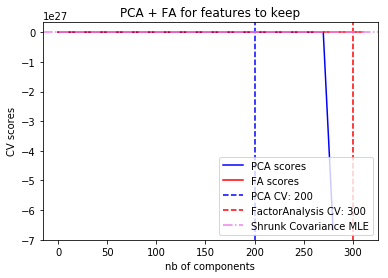

In [28]:
pca_scores, fa_scores = compute_scores(all_x)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

#pca = PCA(svd_solver='full', n_components='mle')
#pca.fit(all_x)
#n_components_pca_mle = pca.n_components_

print("\nbest n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
#print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
#plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa,
            linestyle='--')
#plt.axvline(n_components_pca_mle, color='k',
#            label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

# compare with other covariance estimators
plt.axhline(shrunk_cov_score(all_x), color='violet',
            label='Shrunk Covariance MLE', linestyle='-.')
#plt.axhline(lw_score(all_x), color='orange',
#            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('PCA + FA for features to keep')

plt.show()